In [1]:
# !pip install transformers --quiet
# !pip install opendatasets --quiet

# import opendatasets as od
# od.download('https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection')

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer , AutoModel
from torch.utils.data import Dataset , DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
data_df = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json' , lines = True)
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.drop(['article_link'],inplace=True,axis=1)
print(data_df.shape)
data_df.head()

(26708, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
x_train , x_test , y_train , y_test = train_test_split(np.array(data_df['headline']),np.array(data_df['is_sarcastic']),test_size=0.3)
x_val , x_test , y_val , y_test = train_test_split(x_test , y_test , test_size=0.5)

print("Train size : ", x_train.shape[0],'which is :',round(x_train.shape[0]/data_df.shape[0],4)*100 , '%')
print("val size : ", x_val.shape[0],'which is :',round(x_val.shape[0]/data_df.shape[0],4)*100 , '%')
print("test size : ", x_test.shape[0],'which is :',round(x_test.shape[0]/data_df.shape[0],4)*100 , '%')

Train size :  18695 which is : 70.0 %
val size :  4006 which is : 15.0 %
test size :  4007 which is : 15.0 %


In [5]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

2025-06-30 06:54:43.937812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751266484.147707      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751266484.206883      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
# original -> ['Hello how are you']
# tokens -> [432,421,998,811 , 0,0,0,....,0]

In [7]:
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X = [tokenizer(x,
                        max_length = 100,
                        truncation = True,
                        padding = 'max_length',
                        return_tensors = 'pt').to(device)
                        for x in X
    ]
    self.Y = torch.tensor(Y, dtype= torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx] , self.Y[idx]

training_data = dataset(x_train,y_train)
validation_data = dataset(x_val,y_val)
testing_data = dataset(x_test,y_test)

In [8]:
BATCH_SIZE = 32
EPOCH = 10
LR = 1e-4

In [9]:
train_dataloader = DataLoader(training_data,batch_size=BATCH_SIZE,shuffle=True)
validation_dataloader = DataLoader(validation_data,batch_size=BATCH_SIZE,shuffle=True)
testing_dataloader = DataLoader(testing_data,batch_size=BATCH_SIZE,shuffle=True)

In [10]:
inputs = tokenizer("Hello, how are you?", return_tensors="pt")
# ส่งข้อมูลเข้าโมเดล
with torch.no_grad():
    outputs = bert_model(**inputs)

# outputs.last_hidden_state คือผลลัพธ์ของทุกๆ Token
last_hidden_state = outputs.last_hidden_state
print("Shape of last_hidden_state:", last_hidden_state.shape)

# เลือกเอาเฉพาะเวกเตอร์ของ [CLS] token (ตัวแรกสุด)
cls_vector = last_hidden_state[:, 0, :]
print("Shape of [CLS] vector:", cls_vector.shape)

Shape of last_hidden_state: torch.Size([1, 8, 768])
Shape of [CLS] vector: torch.Size([1, 768])


In [11]:
class MyModel(nn.Module):
  def __init__(self , bert):
    super(MyModel,self).__init__()

    self.bert = bert
    self.dropout = nn.Dropout(0.25)
    self.linear1 = nn.Linear(768,384)
    self.linear2 = nn.Linear(384,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self , input_ids,attention_mask):
    pooled_output = self.bert(input_ids,attention_mask,return_dict= False)[0][:,0]
    output = self.linear1(pooled_output)
    output = self.dropout(output)
    output = self.linear2(output)
    output = self.sigmoid(output)
    return output

In [12]:
for param in bert_model.parameters():
  param.requires_grad = False

model = MyModel(bert_model).to(device)

In [13]:
model

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [14]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr = LR)

In [15]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCH):
  total_loss_train = 0
  total_loss_val = 0
  total_acc_train = 0
  total_acc_val = 0

  for indx , data in enumerate(train_dataloader):
    inputs , labels = data
    inputs.to(device)
    labels.to(device)

    prediction = model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)

    batch_loss = criterion(prediction,labels)
    total_loss_train += batch_loss.item()

    acc = (prediction.round() == labels).sum().item()

    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for indx , data in enumerate(validation_dataloader):
      inputs , labels = data
      inputs.to(device)
      labels.to(device)

      prediction = model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)

      batch_loss = criterion(prediction,labels)
      total_loss_val += batch_loss.item()

      acc = (prediction.round() == labels).sum().item()

      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))
  total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100,4))
  total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()*100,4))

  print(f'''
  Epoch No. {epoch+1}/{EPOCH} Train Loss : {round(total_loss_train/1000,4)} Train Accuracy : {round(total_acc_train/training_data.__len__()*100,4)}
                              val Loss : {round(total_loss_val/1000,4)} val Accuracy : {round(total_acc_val/validation_data.__len__()*100,4)}
  '''
  )


  Epoch No. 1/10 Train Loss : 0.2591 Train Accuracy : 80.1284
                              val Loss : 0.0482 val Accuracy : 83.999
  

  Epoch No. 2/10 Train Loss : 0.2121 Train Accuracy : 84.445
                              val Loss : 0.0454 val Accuracy : 84.3485
  

  Epoch No. 3/10 Train Loss : 0.1993 Train Accuracy : 85.3383
                              val Loss : 0.0427 val Accuracy : 85.6216
  

  Epoch No. 4/10 Train Loss : 0.1914 Train Accuracy : 86.039
                              val Loss : 0.0423 val Accuracy : 85.7713
  

  Epoch No. 5/10 Train Loss : 0.1871 Train Accuracy : 86.2156
                              val Loss : 0.0415 val Accuracy : 85.8213
  

  Epoch No. 6/10 Train Loss : 0.1844 Train Accuracy : 86.3118
                              val Loss : 0.0422 val Accuracy : 85.7713
  

  Epoch No. 7/10 Train Loss : 0.1827 Train Accuracy : 86.483
                              val Loss : 0.0407 val Accuracy : 86.0709
  

  Epoch No. 8/10 Train Loss : 0.1805 Train A

In [19]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for indx , data in enumerate(testing_dataloader):
        inputs, labels =data
        inputs.to(device)
        labels.to(device)

        prediction = model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)

        batch_loss = criterion(prediction,labels)
        total_loss_test += batch_loss

        acc = (prediction.round() == labels).sum().item()

        total_acc_test += acc
        
print(f"Accuracy : {round(total_acc_test/testing_data.__len__()*100,4)} %")

Accuracy : 85.9246 %


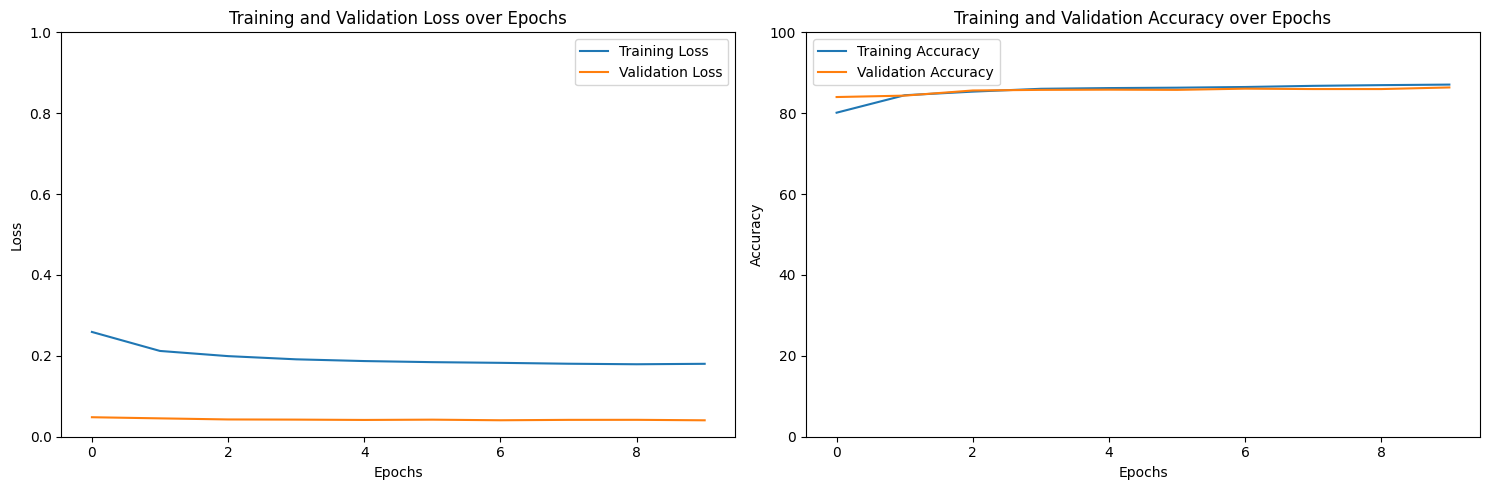

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()